# Notebook to explore group differences

In [536]:
from nfact_id.functions.modelling_fuc import get_zscores_distrubtions
import seaborn as sns
sns.set_style("darkgrid")
import numpy as np
import xarray as xr
import arviz as az
from decouple import config
from scipy.stats import beta
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import os
import numpy as np
from scipy.stats import norm

## Get dataframe

In [537]:
component_dir = os.path.join(config("base_dir"), "component_loadings", "hcp")
storage_dir = os.path.join(config("base_dir"), "group_tests")

In [538]:
G_patients = pd.read_csv(os.path.join(storage_dir, "grey_ppc.csv"))
W_patients = pd.read_csv(os.path.join(storage_dir, "white_ppc.csv"))

## Load the models

In [539]:
idata_ctrl_white = az.from_netcdf(os.path.join(storage_dir, "normative_WM_fitted.nc"))
idata_ctrl_grey = az.from_netcdf(os.path.join(storage_dir, "normative_GM_fitted.nc"))

## Put working on functions here

Aim to put these in a different file

In [540]:
def is_meaningful(z_posteriors: xr.DataArray, log_po: int = -2.94, meaningful: int = 0.1) -> list:
    """
    Function to see if individual
    z score posteriors are meaningful

    Parameters
    ----------
    z_posteriors: xr.DataArray
        DataArray of posteriors 
        to loop over
    log_po: int = -2.94
        log_po cut off 
    meaningful: int = 0.1
        mean cut off
    
    Returns
    -------
    list: list 
        list of indcies
        of meaningful values

    """
    return [
    sub for sub in range(z_posteriors.shape[0])
    if (
        (abs((mass_dict := rope_mass(z_posteriors[sub].stack(sample=("chain", "draw"))))["mean"]) > meaningful)
        and (mass_dict["log_po"] <= log_po)
    )
]

In [541]:
def check_values(val):
    return True if val > 0 else False


In [542]:
def get_log_posterior_odds(alt_val, null_val):
    if not check_values(alt_val): return 9999
    if not check_values(null_val): return -9999
    return np.log(null_val / alt_val)

In [543]:
def get_posterior_odds(alt_val, null_val):
    if not check_values(alt_val): return -9999
    if not check_values(null_val): return 9999
    return alt_val / null_val 

In [544]:
def get_rope_mass(posterior: xr.DataArray, rope: tuple):
    lower, upper = rope
    inside = np.mean((posterior > lower) & (posterior < upper))   
    below  = np.mean(posterior <= lower)
    above  = np.mean(posterior >= upper)
    outside = below + above
    return {
        "inside": inside,
        "outside": outside
    }



In [545]:
def rope_mass(posterior: xr.DataArray, rope: tuple =(-0.1, 0.1)) -> dict:
    """
    A rope mass diagnostic function. 
    Returns ROPE mass, posterior odds
    (basically a bayes factor) and bayes factor 
    for the null hypothesis (that there 
    is no effect, i.e everything is inside ROPE)

    Parameters
    -----------
    posterior: xr.DataArray
        posterior data
    rope: tuple
        tuple of rope range (-0.1, 0.1)
    
    Returns
    -------
    dict: dictionary
       dict of inside, above and below
       rope mass, posterior odds and
       null bayes factor
    """
    posterior = posterior.to_numpy()
    rope_mass = get_rope_mass(posterior, rope)
 
    posterior_odds = get_posterior_odds(
        rope_mass['outside'], 
        rope_mass['inside'])

    log_odds_null = get_log_posterior_odds(rope_mass['outside'], rope_mass['inside']) 
    mean = posterior.mean()
    return {
        "mean": mean,
        "inside": rope_mass['inside']*100, 
        "outside": rope_mass['outside']*100,
        "posterior_odds": posterior_odds, 
        "bf_01": 1 / posterior_odds,
        "log_po": log_odds_null
    }

In [546]:
def reshape_posteriors(zscores: xr.Dataset, no_subjects: int, no_components: int) -> xr.DataArray:
    """
    Function to reshape posteriors into
    'wide' format 

    Paramaters
    ----------
    zscores: xr.DataArray
        xr.Dataset with zscores in
        them
    no_subjects: int
        number of subjects
    no_components: int
        number of components

    Returns
    --------
    xr.DataArray: dataarray
        data array of
        subject, component
        chain, draw
    """

    return xr.DataArray(
        zscores.data.reshape(
            no_subjects, 
            no_components, 
            zscores.chain.size, 
            zscores.draw.size),
        dims=( "sub", "comp", "chain", "draw")
    )

In [547]:
def beta_distribution(outside_total: int, total_number: int) -> xr.DataArray:
    """
    Function to get the beta 
    distribtuion given number of samples
    outside a set condition 
    (i.e number of subjects outside ROPE) and total number
    of samples (i.e total number of population)

    Parameters
    ----------
    outside_total: int
        int of the number of samples
        outside a given condition
    total_number: int
        total number of samples
    
    Returns
    -------
    xr.DataArray: DataArray
        xr data array of posterior
        distrubtion
    """
    alpha =  1 + outside_total
    beta_param = 1 + total_number - outside_total
    posterior_samples = beta.rvs(alpha, beta_param, size=4000)
    return az.from_dict(posterior={"theta": posterior_samples})

In [443]:
def get_zscore_summary(z_scores: xr.Dataset) -> pd.DataFrame:
    """
    Function to get a summary of zscores
    from zscores distrubtion

    Parameters
    ----------
    z_scores: xr.Dataset

    Returns
    -------
    pd.DataFrame: Dataframe
        DataFrame of mean, hdi_2.5%
        and hdi_97.5%
    """
    return az.summary(z_scores, hdi_prob=0.95, kind='stats')[['mean', 'hdi_2.5%', "hdi_97.5%"]].reset_index(drop=True)

In [548]:
def mask_condition(z_scores: pd.DataFrame) -> pd.Series:
    """
    Function to create a mask 
    based on if the mean and hdi are outside 
    of ROPE (strictest)

    Parameter
    ---------
    z_scores: pd.DataFrame
        z_scores
    
    Returns
    -------
    pd.Series: Series
        Series of bool values
    """
    return (
        ((z_scores['hdi_2.5%'] > 0.1) & (z_scores['hdi_97.5%'] > 0.1))
        | ((z_scores['hdi_2.5%'] < -0.1) & (z_scores['hdi_97.5%'] < -0.1))
    ) & (z_scores['mean'].abs() > 0.1)

In [549]:
def perc_affected_from_cohen_d(cohen_d: np.ndarray) -> np.ndarray:
    """
    Function to get a 
    non-overlap percentage given a 
    cohen_ds distrubtion

    Parameters
    ----------
    cohen_d: np.ndarray
        distrubtion of posterior
        given a set cohens d value
    
    Returns
    -------
    np.ndarray: array
        distrubtion of percentage value
    """
    overlap = 2 * norm.cdf(-np.abs(cohen_d)/2)
    return (1 - overlap) * 100

def get_posterior_for_d(
        cohen_d: float, 
        se:float = 0.05, 
        prior_mean: float = 0.0, 
        prior_sd: float = 0.5, 
        n_samps: int= 2000) -> np.ndarray:
    """
    Function to get posterior given 
    a set cohens d

    Parameters
    ----------
    cohen_d: float
        effect size 
    se: float
        standard error
        Default is 0.05
    prior_mean: float = 0.0
        mean of prior 
        distribution
    prior_sd: float = 0.5
        standard deviation
        of prior
    n_samps: int 
        number samples to draw 
        from the posterior
        Default is 2000.

    Returns
    --------
    np.ndarray: array
        Posterior distribution
    """
    prior_var = prior_sd**2
    lik_var = se**2
    post_var = 1/(1/prior_var + 1/lik_var)
    post_mean = post_var * (prior_mean/prior_var + cohen_d/lik_var)
    post_sd = np.sqrt(post_var)
    return np.random.normal(post_mean, post_sd, n_samps)


def get_expected_value(
        cohen_d: float, 
        se:float = 0.05, 
        prior_mean: float = 0.0, 
        prior_sd: float = 0.5, 
        n_samps: int= 2000) -> np.ndarray:
    """
    Function to get posterior given 
    a set cohens d

    Parameters
    ----------
    cohen_d: float
        effect size 
    se: float
        standard error
        Default is 0.05
    prior_mean: float = 0.0
        mean of prior 
        distribution
    prior_sd: float = 0.5
        standard deviation
        of prior
    n_samps: int 
        number samples to draw 
        from the posterior
        Default is 2000.

    Returns
    --------
    np.ndarray: array
        Posterior distribution
    """
    dist = get_posterior_for_d(
        cohen_d, 
        se, 
        prior_mean, 
        prior_sd, 
        n_samps)
    percentage_distribution = perc_affected_from_cohen_d(dist)
    return {
        "mean": np.mean(percentage_distribution),
        "hdi_95": np.percentile(percentage_distribution, [2.5, 97.5])
    }

In [550]:
def get_meaningful_values(z_posteriors: xr.DataArray, df_comp_vals: pd.DataFrame, log_po: int = -2.94, meaningful: int = 0.1) -> list:
    """
    Function to see if individual
    z score posteriors are meaningful

    Parameters
    ----------
    z_posteriors: xr.DataArray
        DataArray of posteriors 
        to loop over
    log_po: int = -2.94
        log_po cut off 
    meaningful: int = 0.1
        mean cut off
    
    Returns
    -------
    list: list 
        list of indcies
        of meaningful values

    """
    df = df_comp_vals.copy(deep=True)
    df['z_score'] = None
    for idx, sub_comp in enumerate(z_posteriors.stack(samples=("chain", "draw"))):
        mass = rope_mass(sub_comp)
        if np.abs(mass['mean']) < meaningful:
            df.loc[idx, 'z_score'] = 0
            continue
        if mass['log_po'] > log_po:
            df.loc[idx, 'z_score'] = 0
            continue
        df.loc[idx, 'z_score'] = df.loc[idx, 'mean']
    return df

## Calculate z score distrubtions

In [551]:
g_zscores = get_zscores_distrubtions(idata_ctrl_grey, G_patients['value'].to_numpy())
w_zscores = get_zscores_distrubtions(idata_ctrl_white, W_patients['value'].to_numpy())

## Get z score summaries

In [552]:
w_summary = get_zscore_summary(w_zscores)
g_summary = get_zscore_summary(g_zscores)

## Reshape posterior to be more informative

In [553]:
wm_posteriors = reshape_posteriors(w_zscores, W_patients['subject'].unique().shape[0], W_patients['component_num'].unique().shape[0] )
gm_posteriors = reshape_posteriors(g_zscores, G_patients['subject'].unique().shape[0], G_patients['component_num'].unique().shape[0] )

## Create dataframes with summary stats by group and component type

In [555]:
w_scores = pd.concat([W_patients.reset_index(drop=True), w_summary.reset_index(drop=True)], axis=1)
g_scores = pd.concat([G_patients.reset_index(drop=True), g_summary.reset_index(drop=True)], axis=1)

## Group differences

The approach is two fold. 
1) Overall Summation measure. The Idea is can component loadings be summed into a single meteric and is that meaningful
2) Do individual components differ by group?

For all group analysis a ROPE of 0.1 (effect size was picked based on Friston et al., 2002)

## Summation

The analysis plan for this is:

1) Find the number of patients that meet the follow criteria:
    - mean of distubtion > 0.1 (or having an effect greater than a cohen's d of 0.1)
    - The log posterior probiablity of 95% of distubtion outside ROPE (Masharipov et al., 2021)
2) Esitmate θ = propoation of patients with a meaningul effect or number of meaningful patients∼Binomial(n,θ)
3) Do this process across all patients, sub groups and white/grey matter

### Get the subjects and group identifiers that correspond to the scores

Given the long_df was used to predict the PPC the summation dataframes from earlier have the correct ordering

In [570]:
w_data_wide['group'].unique()

array(['Anxiety', 'Control', 'Depression', 'psychosis'], dtype=object)

In [557]:
w_data_wide = w_scores.pivot(
    index=['subject', 'group'],   
    columns='component_num',     
    values=['mean'],
).reset_index().sort_values(by='group').reset_index(drop=True)
w_data_wide.columns = [f"{comp} {comp_num}".rstrip() for comp , comp_num in w_data_wide.columns]

In [589]:
g_data_wide = g_scores.pivot(
    index=['subject', 'group'],   
    columns='component_num',     
    values=['mean'],
).reset_index().sort_values(by='group').reset_index(drop=True)
g_data_wide.columns = [f"{comp} {comp_num}".rstrip() for comp , comp_num in g_data_wide.columns]

### Get the posteriors for each subjects summation statistic

In [630]:
w_all = wm_posteriors.mean("comp")
g_all = gm_posteriors.mean("comp")
w_subjects_sum = w_all[w_data_wide[~w_data_wide['group'].str.contains("Control")].index]
g_subjects_sum = g_all[g_data_wide[~g_data_wide['group'].str.contains("Control")].index]
w_controls_sum = w_all[w_data_wide[w_data_wide['group'].str.contains("Control")].index]
g_controls_sum = g_all[g_data_wide[g_data_wide['group'].str.contains("Control")].index]

In [678]:
mean_w_sub = w_data_wide[~w_data_wide['group'].str.contains("Control")].reset_index(drop=True).iloc[w_meaningful].reset_index(drop=True)

In [679]:
mean_w_sub

,subject,group,mean 0,mean 1,mean 2,mean 3,mean 4,mean 5,mean 6,mean 7,...,mean 90,mean 91,mean 92,mean 93,mean 94,mean 95,mean 96,mean 97,mean 98,mean 99
0,BANDA055,Anxiety,-2.057,-0.748,-0.810,0.514,0.109,0.463,-0.422,1.002,...,0.229,1.186,0.765,-3.560,0.833,-0.210,-0.906,0.459,0.026,-2.081
1,BANDA056,Anxiety,1.940,-1.227,0.723,-0.732,0.783,-1.671,-1.198,0.574,...,0.198,-6.040,0.192,1.867,-1.654,0.819,0.393,0.351,-0.607,0.270
2,BANDA027,Anxiety,1.418,0.123,0.203,0.594,0.022,0.033,0.302,-0.167,...,0.094,-3.096,-0.105,1.019,1.596,0.625,0.732,-0.366,0.948,-0.163
3,BANDA032,Anxiety,1.200,-0.394,1.633,1.180,-0.115,0.778,0.359,0.780,...,0.844,1.759,0.441,0.923,0.991,0.137,1.659,-0.471,0.626,0.009
4,BANDA093,Anxiety,-0.029,0.815,1.077,1.366,-0.890,-0.787,1.108,0.525,...,0.315,0.271,-0.104,1.797,0.281,-0.100,-0.809,0.322,-0.278,-0.696
5,BANDA191,Anxiety,1.369,-0.078,-1.781,1.140,0.726,0.553,-0.689,0.495,...,0.038,-2.478,0.193,-1.783,-1.387,0.400,0.199,-1.010,0.518,0.056
6,BANDA192,Anxiety,0.367,-0.896,-1.964,0.121,-2.270,-0.832,-1.807,0.778,...,-0.401,1.356,-0.237,-4.943,0.338,-1.300,1.056,-0.282,-0.315,0.123
7,e0038,Depression,-1.110,0.829,1.916,-0.137,0.586,1.467,1.334,-0.141,...,0.226,1.632,0.885,-0.298,0.675,-0.289,0.132,0.422,0.403,0.035
8,e0064,Depression,0.610,0.735,-0.349,1.290,-0.601,0.036,1.205,-0.724,...,-0.071,0.029,-0.702,-2.558,0.967,0.106,-0.159,0.549,0.836,-0.143
9,s0073,Depression,-0.500,-1.718,0.162,1.250,-3.596,0.680,0.997,1.317,...,0.582,0.652,0.636,0.848,-0.399,0.232,-0.156,0.329,0.752,0.774


In [603]:
white_sum = az.summary(w_controls_sum, hdi_prob=0.95)
grey_sum = az.summary(g_controls_sum, hdi_prob=0.95)

### Get the number of subjects with a meaningful difference compared to controls

Controls referenced in the codde below is the hold out dataset

In [ ]:
patient_numbers = w_data_wide[~w_data_wide['group'].str.contains("HC")].shape[0]
control_numbers = w_data_wide[w_data_wide['group'].str.contains("HC")].shape[0]
w_meaningful = is_meaningful(w_subjects_sum)
g_meaningful = is_meaningful(g_subjects_sum)

#### Get the distrubtions of meaningful posterior distrubtions

In [635]:
w_meaningful_patients = w_subjects_sum[w_meaningful].mean(dim="sub")
g_meaningful_patients = g_subjects_sum[g_meaningful].mean(dim="sub")


percentage_affected = {
        "White Matter": round((len(w_meaningful)/patient_numbers) * 100, 2),
        "Grey Matter": round((len(g_meaningful)/patient_numbers) * 100, 2)
}

g_rope = [grey_sum["hdi_2.5%"].mean(), grey_sum["hdi_97.5%"].mean()]
w_rope = [white_sum["hdi_2.5%"].mean(), white_sum["hdi_97.5%"].mean()]

### Plot the efect sizes across all patients and controls

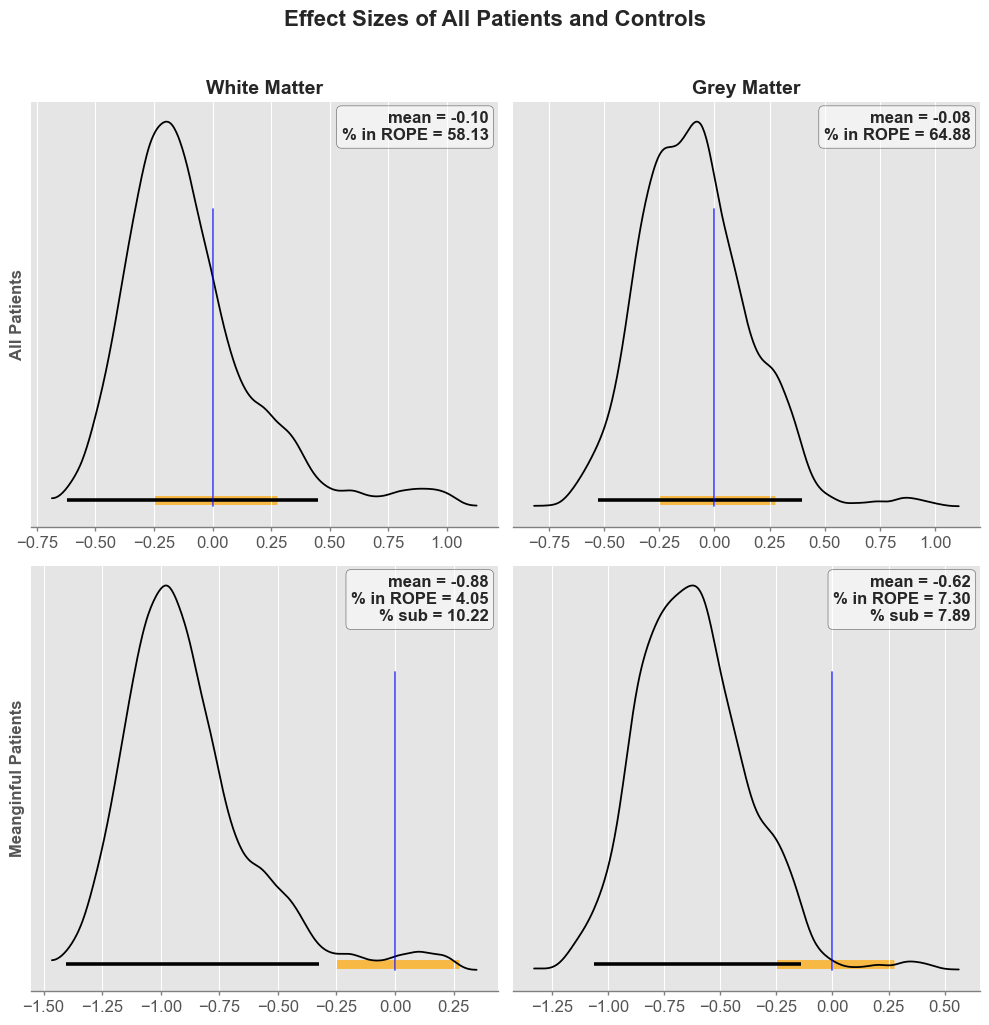

In [667]:
# Data and labels
data_sets = [
    (w_subjects_sum.mean(dim="sub"), g_subjects_sum.mean(dim="sub"), "All Patients"),
    (w_meaningful_patients, g_meaningful_patients, "Meanginful Patients"),
]

col_titles = ["White Matter", "Grey Matter"]
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for row, (w_data, g_data, row_title) in enumerate(data_sets):
    for col, (data, ctitle) in enumerate(zip([w_data, g_data], col_titles)):
        if col_titles == "White Matter":
            rope = w_rope
        else:
            rope = g_rope
        ax = axes[row, col]
        az.plot_posterior(
            data,
            hdi_prob=0.95,
            ref_val=0,
            rope=rope,
            ax=ax,
            textsize=12,
            color="black",
            rope_color="orange",
            ref_val_color="blue",
        )
        # Clear default title
        ax.set_title("")

        # Add column titles only in the first row
        if row == 0:
            ax.set_title(ctitle, fontsize=14, fontweight="bold")

        # Add row titles on left side
        if col == 0:
            ax.set_ylabel(row_title, fontsize=12, fontweight="bold")

        # Remove ArviZ default text (mean/HDI)
        for txt in list(ax.texts):
            txt.remove()

        mean_val = data.mean().item()
        rope_pct = 100 * ((data > rope[0]) & (data < rope[1])).mean().item()
        

        # Add annotation box
        box_text = (
            f"mean = {mean_val:.2f}\n"
            f"% in ROPE = {rope_pct:.2f}"
            
        )
        if row_title == "Meanginful Patients":
            perc_effect = percentage_affected[ctitle]
            box_text = box_text + (f"\n% sub = {perc_effect}")
        ax.text(
            0.98,
            0.98,
            box_text,
            transform=ax.transAxes,
            ha="right",
            va="top",
            fontsize=12,
            fontweight="bold",
            bbox=dict(
                facecolor="white",
                alpha=0.5,
                edgecolor="black",
                boxstyle="round,pad=0.3",
            ),
        )
fig.suptitle("Effect Sizes of All Patients and Controls", fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()


### Get the number in each sub group

In [ ]:
w_data_wide[~w_data_wide['group'].str.contains("Control")].reset_index(drop=True).iloc[w_meaningful].reset_index(drop=True)[0:]

,subject,group,mean 0,mean 1,mean 2,mean 3,mean 4,mean 5,mean 6,mean 7,...,mean 90,mean 91,mean 92,mean 93,mean 94,mean 95,mean 96,mean 97,mean 98,mean 99
0,BANDA055,Anxiety,-2.057,-0.748,-0.810,0.514,0.109,0.463,-0.422,1.002,...,0.229,1.186,0.765,-3.560,0.833,-0.210,-0.906,0.459,0.026,-2.081
1,BANDA056,Anxiety,1.940,-1.227,0.723,-0.732,0.783,-1.671,-1.198,0.574,...,0.198,-6.040,0.192,1.867,-1.654,0.819,0.393,0.351,-0.607,0.270
2,BANDA027,Anxiety,1.418,0.123,0.203,0.594,0.022,0.033,0.302,-0.167,...,0.094,-3.096,-0.105,1.019,1.596,0.625,0.732,-0.366,0.948,-0.163
3,BANDA032,Anxiety,1.200,-0.394,1.633,1.180,-0.115,0.778,0.359,0.780,...,0.844,1.759,0.441,0.923,0.991,0.137,1.659,-0.471,0.626,0.009
4,BANDA093,Anxiety,-0.029,0.815,1.077,1.366,-0.890,-0.787,1.108,0.525,...,0.315,0.271,-0.104,1.797,0.281,-0.100,-0.809,0.322,-0.278,-0.696
5,BANDA191,Anxiety,1.369,-0.078,-1.781,1.140,0.726,0.553,-0.689,0.495,...,0.038,-2.478,0.193,-1.783,-1.387,0.400,0.199,-1.010,0.518,0.056
6,BANDA192,Anxiety,0.367,-0.896,-1.964,0.121,-2.270,-0.832,-1.807,0.778,...,-0.401,1.356,-0.237,-4.943,0.338,-1.300,1.056,-0.282,-0.315,0.123
7,e0038,Depression,-1.110,0.829,1.916,-0.137,0.586,1.467,1.334,-0.141,...,0.226,1.632,0.885,-0.298,0.675,-0.289,0.132,0.422,0.403,0.035
8,e0064,Depression,0.610,0.735,-0.349,1.290,-0.601,0.036,1.205,-0.724,...,-0.071,0.029,-0.702,-2.558,0.967,0.106,-0.159,0.549,0.836,-0.143


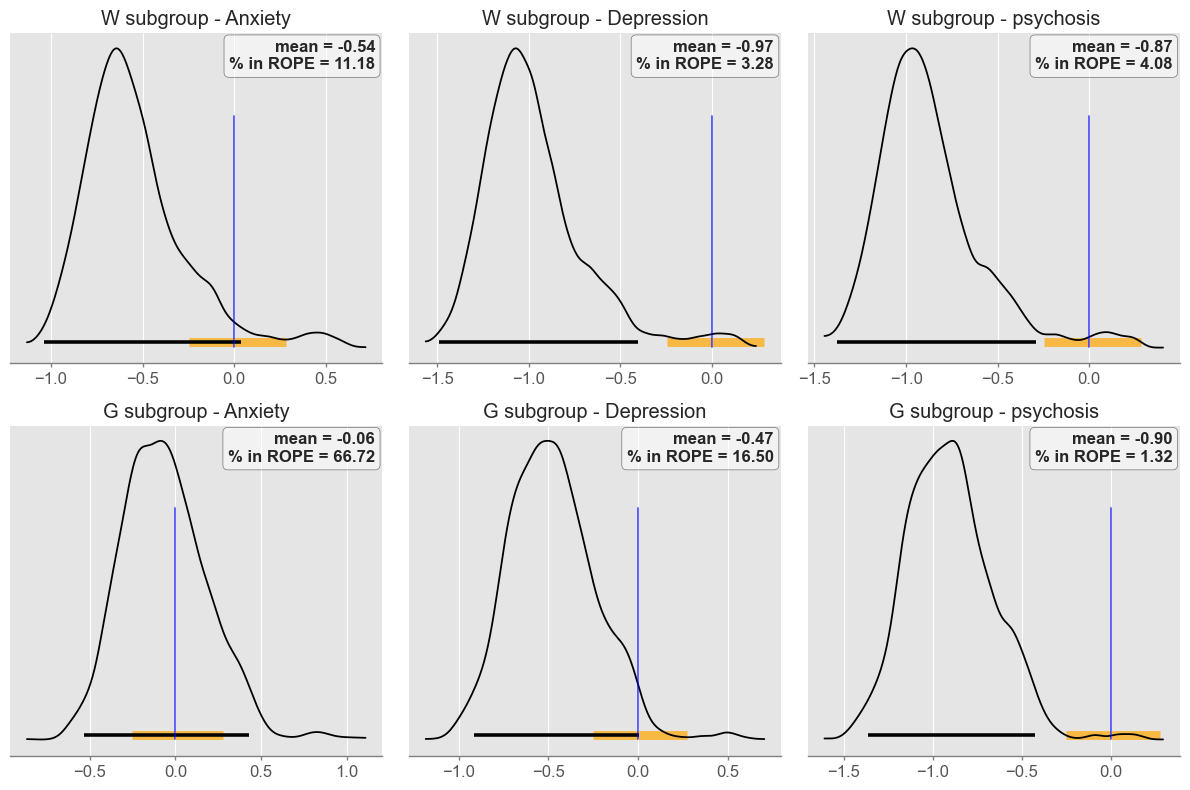

In [688]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))


groups = ["Anxiety", "Depression", "psychosis"]
datasets = [w_subjects_sum[w_meaningful], g_subjects_sum[g_meaningful]]
row_labels = ["W subgroup", "G subgroup"]

for row, dataset in enumerate(datasets):
    for col, group in enumerate(groups):
        # subset the dataset for the group

        if "W" in row_labels[row]:
            rope = w_rope
            idx_data = w_data_wide[~w_data_wide['group'].str.contains("Control")].reset_index(drop=True).iloc[w_meaningful].reset_index(drop=True)
        else:
            rope = g_rope
            idx_data = g_data_wide[~g_data_wide['group'].str.contains("Control")].reset_index(drop=True).iloc[g_meaningful].reset_index(drop=True)
        
        group_idx = idx_data.groupby("group").groups[group]
        subset = dataset[group_idx]
        # average across subjects, but keep draws
        posterior_mean = subset.mean(dim="sub")

        az.plot_posterior(
            posterior_mean,
            hdi_prob=0.95,
            rope=rope,
            ax=ax[row, col],
            textsize=12,
            color="black",
            rope_color="orange",
            ref_val_color="blue",
            ref_val=0
        )
        ax[row, col].set_title(f"{row_labels[row]} - {group}")
        for txt in list(ax[row, col].texts):
            txt.remove()

        mean_val = posterior_mean.mean().item()
        rope_pct = 100 * ((posterior_mean > rope[0]) & (posterior_mean < rope[1])).mean().item()


        # Add annotation box
        box_text = (
            f"mean = {mean_val:.2f}\n"
            f"% in ROPE = {rope_pct:.2f}"
            
        )
  
        ax[row, col].text(
            0.98,
            0.98,
            box_text,
            transform=ax[row, col].transAxes,
            ha="right",
            va="top",
            fontsize=12,
            fontweight="bold",
            bbox=dict(
                facecolor="white",
                alpha=0.5,
                edgecolor="black",
                boxstyle="round,pad=0.3",
            ))
plt.tight_layout()
plt.show()


## Components

This section if finding individual components that differ by group

In [23]:
w_component_df = w_scores.copy(deep=True)
w_component_df['z_score'] = None
g_component_df = g_scores.copy(deep=True)

### Mask out values 

Meaningful values are the same as previously defined. |Z| > 0.1 and log PO < -2.94

In [24]:
w_component_df = get_meaningful_values(w_zscores, w_scores)
g_component_df = get_meaningful_values(g_zscores, g_scores)

In [25]:
w_component_df.columns

Index(['subject', 'group', 'value', 'component_num', 'mean', 'hdi_2.5%',
       'hdi_97.5%', 'z_score'],
      dtype='object')

In [377]:
w_component_df['group'] == "psychosis"

0         True
1         True
2         True
3         True
4         True
         ...  
39595    False
39596    False
39597    False
39598    False
39599    False
Name: group, Length: 39600, dtype: bool

In [382]:
w_component_df[(w_component_df['component_num'] ==88) & (w_component_df['group'] == "psychosis") ].index

Index([   88,   188,   288,   388,   488,   588,   688,   788,   888,   988,
       ...
        9788,  9888,  9988, 10088, 10188, 10288, 10388, 10488, 10588, 10688],
      dtype='int64', length=107)

In [394]:
testyy = w_zscores[w_component_df[(w_component_df['component_num'] == 3) & (w_component_df['group'] == "Depression") ].index].stack(samples=("chain", "draw")).mean(dim=("value_obs"))
test = rope_mass(testyy)
test

{'mean': np.float64(0.20485786624067204),
 'inside': np.float64(25.924999999999997),
 'outside': np.float64(74.075),
 'posterior_odds': np.float64(2.857280617164899),
 'bf_01': np.float64(0.34998312521093483),
 'log_po': np.float64(-1.049870339344038)}

In [154]:
w_comp = w_component_df.drop(g_component_df[g_component_df['z_score'] ==0].index)

In [32]:
comp_defintion = pd.read_csv(os.path.join(config("base_dir"), "component_defintion", "component_defintions.csv"))

In [34]:
comp_defintion['definition']

0               Limbic
1         no_consensus
2          Somatomotor
3          Somatomotor
4             Salience
            ...       
95            Salience
96    Dorsal Attention
97        no_consensus
98              Visual
99              Visual
Name: definition, Length: 100, dtype: object

In [35]:
summary = (
    w_comp.groupby(['component_num', 'group'])
    .agg(
        n_subjects=('subject', 'nunique'),
        total_subjects=('subject', 'count'),
        mean_effect=('z_score', 'mean'),
))

# Get group sizes for percentage calc (unique subjects per group overall)
group_sizes = w_comp.groupby('group')['subject'].nunique()

# Calculate percentage of subjects in each group with this component
summary['perc_subjects'] = (
    summary['n_subjects'] / summary.index.get_level_values('group').map(group_sizes) * 100
).round(2)

summary['perc_subjects'] = (
    summary['n_subjects'] / summary.index.get_level_values('group').map(group_sizes) * 100
).round(2)

# Select only percentage and mean effect columns
summary = summary[['perc_subjects', 'mean_effect']]

# Pivot to wide format: one column per group
summary_wide = summary.reset_index().pivot(
    index='component_num',
    columns='group',
    values=['perc_subjects', 'mean_effect']
)

# Flatten MultiIndex columns
summary_wide.columns = [f"{val}_{grp}" for val, grp in summary_wide.columns]
summary_wide = summary_wide.reset_index()

summary_wide['definition'] = comp_defintion['definition']



In [ ]:
w_comp = w_comp.merge(
    comp_defintion[['Components', 'definition', "IntraHemi"]].rename(columns={"Components": "component_num"}),
    on='component_num',
    how='left'
)
w_comp = w_comp[~w_comp['IntraHemi']]

In [61]:
w_comp = w_comp[~w_comp['IntraHemi']]

In [70]:
(filt == "no_consensus").sum().sum()


np.int64(5)

In [69]:
filt = w_comp[w_comp['subject'] == "1006"]

In [66]:
1947 / 100

19.47

In [ ]:
w_comp['definition']

count            8952
unique             10
top       Somatomotor
freq             1972
Name: definition, dtype: object

In [153]:
g_comp

NameError: name 'g_comp' is not defined

In [155]:
w_comp = w_comp.merge(
    comp_defintion[['Components', 'definition', "IntraHemi"]].rename(columns={"Components": "component_num"}),
    on='component_num',
    how='left'
)
w_comp = w_comp[~w_comp['IntraHemi']]

In [156]:
network_summary = (
    w_comp.groupby(['definition', 'group'])
    .agg(
        mean_effect=('z_score', 'mean'),
        n_subjects=('subject', 'nunique')
    )
    .reset_index()
)

# Pivot to wide so that group-specific values are in separate columns
network_summary_wide = network_summary.pivot(
    index='definition',
    columns='group',
    values=['mean_effect', 'n_subjects']
)

# Flatten MultiIndex columns
network_summary_wide.columns = [
    f"{val}_{grp}" for val, grp in network_summary_wide.columns
]
network_summary_wide = network_summary_wide.reset_index()

In [157]:
network_summary_wide

,definition,mean_effect_Anxiety,mean_effect_Depression,mean_effect_psychosis,n_subjects_Anxiety,n_subjects_Depression,n_subjects_psychosis
0,Auditory,-0.378156,-0.342723,-0.163032,30,87,52
1,Default,-0.437974,-0.450508,-0.516203,77,210,107
2,Dorsal Attention,-0.251521,-0.59597,-0.595456,73,206,103
3,Frontoparietal,-0.148632,-0.762435,-0.51504,57,155,79
4,Language,-0.25787,-0.3354,-0.570604,72,190,93
5,Limbic,-0.380029,-0.682964,-0.464431,30,90,45
6,Salience,-0.49145,-0.490366,-0.542624,75,197,102
7,Somatomotor,-0.131853,-0.598529,-1.11591,76,210,107
8,Visual,-0.137375,-0.177242,-0.188155,57,163,86
9,no_consensus,-0.172778,-0.352704,-0.374286,77,212,107


In [110]:
len(network_summary_wide.index)

10

In [152]:
for row in network_summary_wide.iterrows():
    rope = get_expected_value(row[1]['mean_effect_Anxiety'])["hdi_95"]
    print(rope)
    dis = beta_distribution(row[1]['n_subjects_Anxiety'], no_groups.group.count()["Anxiety"])
    print(rope_mass(dis.posterior.theta, rope=(rope[0], rope[1])))


[39.603249   46.34607178]
{'mean': np.float64(0.32812785272093026), 'inside': np.float64(0.0), 'outside': np.float64(100.0), 'posterior_odds': 9999, 'bf_01': 0.00010001000100010001, 'log_po': -9999}
[21.30245538 28.37540408]
{'mean': np.float64(0.9871612731187372), 'inside': np.float64(0.0), 'outside': np.float64(100.0), 'posterior_odds': 9999, 'bf_01': 0.00010001000100010001, 'log_po': -9999}
[28.52320474 35.65636264]
{'mean': np.float64(0.8490826968355794), 'inside': np.float64(0.0), 'outside': np.float64(100.0), 'posterior_odds': 9999, 'bf_01': 0.00010001000100010001, 'log_po': -9999}
[12.28472967 19.93205906]
{'mean': np.float64(0.5568040120829592), 'inside': np.float64(0.0), 'outside': np.float64(100.0), 'posterior_odds': 9999, 'bf_01': 0.00010001000100010001, 'log_po': -9999}
[31.00892202 38.10991742]
{'mean': np.float64(0.6826179420364549), 'inside': np.float64(0.0), 'outside': np.float64(100.0), 'posterior_odds': 9999, 'bf_01': 0.00010001000100010001, 'log_po': -9999}
[13.16257

In [ ]:
for comp in range(network_summary_wide.index):
    rope = get_expected_value()["hdi"]
    beta_distribution(len(w_sub_groups[group]), no_groups.group.count()[group])
    rope_mass((rope[0], rope[1]))


In [ ]:
w_sub_group_beta_network= {}
w_sub_group_beta_network = {}
for group in network_summary_wide:
    w_beta_dis = beta_distribution(len(w_sub_groups[group]), no_groups.group.count()[group])
    w_sub_group_beta[group] = w_beta_dis
    g_beta_dis = beta_distribution(len(g_sub_groups[group]), no_groups.group.count()[group])
    g_sub_group_beta[group] = g_beta_dis

array([50.37922784, 56.48854359])

In [52]:
network_summary_wide['n_subjects_Depression']

0     68
1    212
2    203
3    141
4    172
5    138
6    194
7    212
8    129
9    211
Name: n_subjects_Depression, dtype: object

In [397]:
get_expected_value(0.7)

{'mean': np.float64(27.110051980616767),
 'hdi_95': array([23.3959338 , 30.83813213])}

In [ ]:
summary

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
component_num,0,0,0,1,1,1,2,2,2,3,...,96,97,97,97,98,98,98,99,99,99
group,Anxiety,Depression,psychosis,Anxiety,Depression,psychosis,Anxiety,Depression,psychosis,Anxiety,...,psychosis,Anxiety,Depression,psychosis,Anxiety,Depression,psychosis,Anxiety,Depression,psychosis
perc_subjects,36.36,37.74,37.38,9.09,11.32,10.28,44.16,39.15,44.86,31.17,...,25.23,18.18,13.68,11.21,11.69,12.74,12.15,14.29,16.04,12.15
mean_effect,0.717643,-0.865388,-1.134925,-1.361714,-0.367833,-1.183545,-0.694647,-1.464651,-1.204354,0.534708,...,-1.41263,-1.249429,-1.172759,-0.699667,-0.250333,-0.909926,-1.115231,-1.333,-1.069118,-1.405308


In [360]:
# Pivot to wide format: subjects × components
df_wide = w_comp.pivot(
    index='subject',
    columns='component_num',
    values='z_score'
)

df_wide.columns = [f"comp{comp}" for comp in df_wide.columns]

# Fill NaN with 0 (or keep NaN if you prefer to ignore missing)
df_wide = df_wide.fillna(0)

# 1) Mean per component across all subjects
component_means = df_wide.mean(axis=0)

# 2) Percentage of subjects with a non-zero value per component
component_nonzero_perc = (df_wide.astype(bool).sum(axis=0) / df_wide.shape[0]) * 100

# Combine into a single DataFrame for convenience
component_summary = pd.DataFrame({
    'mean_value': component_means,
    'perc_subjects_nonzero': component_nonzero_perc.round(2)
})

component_summary

/var/folders/4_/q2h2ppfd6ps35fw_6kl5x9m40000gr/T/ipykernel_1331/3525485553.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_wide = df_wide.fillna(0)


,mean_value,perc_subjects_nonzero
comp0,-0.238722,37.37
comp1,-0.079240,10.61
comp2,-0.512609,41.67
comp3,-0.255851,34.85
comp4,-0.253455,25.76
...,...,...
comp95,-0.271982,22.47
comp96,-0.281503,26.01
comp97,-0.151258,13.89
comp98,-0.104341,12.37


In [ ]:
# Pivot to wide format: subject × group × component z-scores
df_wide_test = w_comp.pivot(
    index=['subject', 'group'],
    columns='component_num',
    values='z_score'
)

# Flatten multi-indexed columns
df_wide_test.columns = [f"comp{comp}" for comp in df_wide_test.columns]

# Reset index for easier manipulation
df_wide_test = df_wide_test.reset_index().fillna(0)

# Long format if needed
df_long = df_wide_test.melt(
    id_vars=['subject', 'group'],
    var_name='component',
    value_name='z_score'
)

# Filter out zeros (where you had set them earlier)
df_long = df_long[np.abs(df_long['z_score']) > 0]


group_means = (
    df_long.groupby(['component', 'group'])['z_score']
    .mean()
    .unstack(fill_value=0)   # pivot groups to columns
)

group_means


/var/folders/4_/q2h2ppfd6ps35fw_6kl5x9m40000gr/T/ipykernel_1331/305917265.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_wide_test = df_wide_test.reset_index().fillna(0)


group,Anxiety,Depression,psychosis
component,,,
comp0,0.717643,-0.865387,-1.134925
comp1,-1.361714,-0.367833,-1.183545
comp10,-1.175000,-1.198824,-1.101615
comp11,-1.449850,-0.918756,-0.799560
comp12,0.113333,-0.576429,-0.521258
...,...,...,...
comp95,-1.340762,-1.188674,-1.130455
comp96,0.279500,-1.245919,-1.412630
comp97,-1.249429,-1.172759,-0.699667


In [343]:
group_means.max()

group
Anxiety       1.916615
Depression    1.004155
psychosis     0.124500
dtype: float64

In [340]:
df_wide_test = w_comp.pivot(
    index=['subject', 'group'],       # keep subject/group as identifiers
    columns='component_num',          # spread across component_num
    values=['z_score']  # values to spread
)

df_wide_test.columns = [f"comp{comp}" for val, comp in df_wide_test.columns]

# Reset index if you want plain columns
df_wide_test = df_wide_test.reset_index().fillna(0)

df_long = df_wide_test.melt(
    id_vars=['subject', 'group'],
    var_name='component',
    value_name='z_score'
)

# Keep only |mean| > 0
df_long = df_long[np.abs(df_long['z_score']) > 0]

# Count unique subjects per group × component
subject_counts = (
    df_long.groupby(['component', 'group'])['subject']
    .nunique()
    .unstack(fill_value=0)  # pivot so groups become columns
)
group_sizes = w_scores.groupby('group')['subject'].nunique()

# Convert counts → percentages
subject_perc = np.round(subject_counts.divide(group_sizes, axis=1) * 100, 2)

subject_perc

/var/folders/4_/q2h2ppfd6ps35fw_6kl5x9m40000gr/T/ipykernel_1331/1108234314.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_wide_test = df_wide_test.reset_index().fillna(0)


group,Anxiety,Depression,psychosis
component,,,
comp0,36.36,37.74,37.38
comp1,9.09,11.32,10.28
comp10,9.09,16.04,12.15
comp11,25.97,21.23,23.36
comp12,23.38,33.02,28.97
...,...,...,...
comp95,27.27,21.70,20.56
comp96,18.18,29.25,25.23
comp97,18.18,13.68,11.21


In [14]:
components_by_group = df_wide_test.groupby("group").mean(numeric_only=True).T
components_by_group = components_by_group.where(np.abs(components_by_group) >= 0.1, 0)


In [15]:
components_by_group

group,Anxiety,Depression,psychosis
comp0,0.000000,-0.279462,-0.274925
comp1,0.000000,0.000000,0.000000
comp2,-0.257974,-0.591226,-0.445542
comp3,0.000000,-0.103596,-0.719280
comp4,-0.100539,-0.179341,-0.271243
...,...,...,...
comp95,0.000000,0.000000,-0.113766
comp96,0.000000,-0.180163,-0.195290
comp97,0.000000,0.000000,0.000000
comp98,0.000000,0.000000,0.000000


In [50]:
w_subjects= single_submation_statistic(w_zscores, W_patients['component_num'].unique().shape[0], W_patients['subject'].unique().shape[0])
w_component = single_submation_statistic(w_zscores, W_patients['subject'].unique().shape[0], W_patients['component_num'].unique().shape[0])

g_subjects= single_submation_statistic(g_zscores, G_patients['component_num'].unique().shape[0], G_patients['subject'].unique().shape[0])
g_component = single_submation_statistic(g_zscores, G_patients['subject'].unique().shape[0], G_patients['component_num'].unique().shape[0])

In [52]:
sub_summ = az.summary(sub, kind='stats', hdi_prob=0.95)
comp_summ = az.summary(comp, kind='stats', hdi_prob=0.95)

In [252]:
np.log(1e-8/1e-8)

np.float64(0.0)

In [259]:
rope_mass(anxiety_sum[0].stack(sample=("chain", "draw")).to_numpy())

{'inside': np.float64(23.674999999999997),
 'below': np.float64(9.275),
 'above': np.float64(67.05),
 'posterior_odds': np.float64(3.223864836325238),
 'bf_01': np.float64(0.3101867016049787)}

In [260]:
np.log(0.95/0.05)

np.float64(2.9444389791664403)

In [ ]:
np.log(mass_dict['inside'] / (mass_dict['below'] + mass_dict['above'])

In [301]:
count

57

In [280]:
count

57

In [231]:
LPO_null

np.float64(0.033262348702956177)

np.float64(83.77499999999999)

In [238]:
LPO_null

np.float64(-1.64158137103322)

In [ ]:
LPO_null = np.log(mass_dict['inside'] / (mass_dict['below'] + mass_dict['above']))

np.float64(-4.59511985013459)

In [223]:
import numpy as np

posterior = np.random.normal(loc=0, scale=0.5, size=4000)


In [224]:
rope_mass(posterior)

{'inside': np.float64(15.875),
 'below': np.float64(41.325),
 'above': np.float64(42.8),
 'posterior_odds': np.float64(5.299212598425197),
 'bf_01': np.float64(0.1887072808320951)}

In [ ]:
rope_mass(psych_sum.mean(dim="chain").to_numpy())

{'inside': np.float64(20.246728971962614),
 'below': np.float64(51.66542056074766),
 'above': np.float64(28.08785046728972),
 'posterior_odds': np.float64(3.9390694239290993),
 'bf_01': np.float64(0.25386706665416703)}

In [131]:
rope_mass(psych_sum.to_numpy())

{'inside': np.float64(19.06518691588785),
 'below': np.float64(51.896261682242994),
 'above': np.float64(29.03855140186916),
 'posterior_odds': np.float64(4.245162318165664),
 'bf_01': np.float64(0.2355622529958054)}

In [127]:
rope_mass(depress_sum)

{'inside': <xarray.DataArray 'x' ()> Size: 8B
 array(19.88042453),
 'below': <xarray.DataArray 'x' ()> Size: 8B
 array(45.35306604),
 'above': <xarray.DataArray 'x' ()> Size: 8B
 array(34.76650943),
 'posterior_odds': <xarray.DataArray 'x' ()> Size: 8B
 array(4.03007367),
 'bf_01': <xarray.DataArray 'x' ()> Size: 8B
 array(0.24813442)}

In [166]:
means = comp.mean(dim=("chain", 'draw'))
for comp_num in range(100):
    if np.abs(means[comp_num].to_numpy()) < 0.1:
        continue
    stat = rope_mass(comp.stack(sample=("chain", "draw"))[comp_num].to_numpy())
    outside = stat['below'] + stat['above']
    print(f"component {comp_num}")
    print("inside rope: ", stat['inside'])
    print("outside rope: ", outside)
    print("odds: ", stat['posterior_odds'])
    print("mean: ", means[comp_num].to_numpy())
    print("-"*10)

component 0
inside rope:  17.9
outside rope:  82.1
odds:  4.58659217877095
mean:  -0.1497065239404547
----------
component 2
inside rope:  7.675
outside rope:  92.32499999999999
odds:  12.029315960912053
mean:  -0.3664185949688152
----------
component 3
inside rope:  16.575
outside rope:  83.425
odds:  5.033182503770739
mean:  -0.17301664788611712
----------
component 4
inside rope:  19.85
outside rope:  80.15
odds:  4.037783375314861
mean:  -0.13585510365933584
----------
component 5
inside rope:  23.625
outside rope:  76.375
odds:  3.232804232804233
mean:  -0.10526481606365612
----------
component 7
inside rope:  22.3
outside rope:  77.7
odds:  3.4843049327354256
mean:  -0.10263503536534721
----------
component 13
inside rope:  11.375
outside rope:  88.625
odds:  7.791208791208791
mean:  -0.2619029788650883
----------
component 14
inside rope:  12.425
outside rope:  87.575
odds:  7.048289738430584
mean:  -0.2357405998883066
----------
component 15
inside rope:  22.525000000000002
out

In [78]:
sub_summ[mask_condition(sub_summ)]

,mean,sd,hdi_2.5%,hdi_97.5%
x[11],-0.855,0.307,-1.397,-0.184
x[17],-0.822,0.306,-1.375,-0.210
x[22],-0.742,0.309,-1.316,-0.109
x[29],-0.925,0.307,-1.459,-0.252
x[40],-0.949,0.305,-1.499,-0.328
x[52],-0.837,0.306,-1.357,-0.137
x[58],-1.277,0.309,-1.819,-0.623
x[61],-1.478,0.306,-2.026,-0.853
x[78],-0.779,0.307,-1.338,-0.140
x[80],-0.796,0.308,-1.346,-0.146


In [11]:
patient_wide_df = df_wide[~df_wide['group'].str.contains("Control")]

### White matter

In [311]:
probability_of_null = (dis.posterior.theta <= 0.10).mean()

In [306]:
rope_probability = (dis.posterior.theta < 0.1).mean()


In [308]:
dis.posterior.theta*0.1

<xarray.DataArray 'theta' (chain: 1, draw: 4000)> Size: 32kB
array([[0.0150756 , 0.01466205, 0.01441033, ..., 0.01459133, 0.01508356,
        0.01753417]], shape=(1, 4000))
Coordinates:
  * chain    (chain) int64 8B 0
  * draw     (draw) int64 32kB 0 1 2 3 4 5 6 ... 3994 3995 3996 3997 3998 3999

In [ ]:
(dis[''] < 0.1).mean()

TypeError: '<' not supported between instances of 'InferenceData' and 'float'

<Axes: title={'center': 'theta'}>

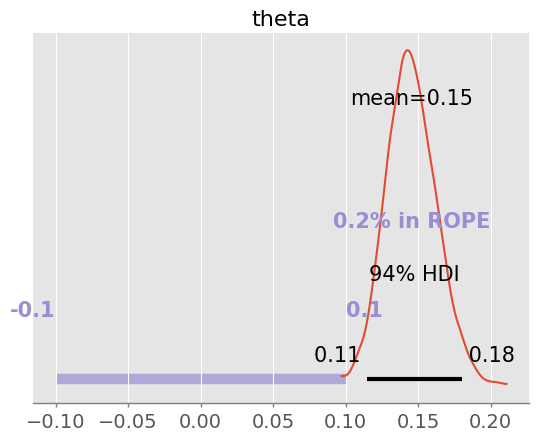

In [309]:
az.plot_posterior(dis, rope=[-0.1, 0.1])

In [8]:
num_subjects = 396
num_components = 100
zscores_multiindex = w_zscores.assign_coords(
    subject=(
        ("value_obs",),
        np.repeat(np.arange(num_subjects), num_components)
    ),
    component=(
        ("value_obs",),
        np.tile(np.arange(num_components), num_subjects)
    )
).set_index(value_obs=("subject", "component"))

# Unstack the MultiIndex to create the new dimensions
zscores_reshaped = zscores_multiindex.unstack("value_obs")

# Now, average the data over the 'subject' dimension
component_distributions = zscores_reshaped.mean(dim="subject")

In [7]:
w_zscores

<xarray.DataArray 'zscores' (value_obs: 39600, chain: 4, draw: 1000)> Size: 1GB
array([[[-0.28122418, -0.85026212, -0.75501406, ..., -1.35824853,
         -1.24513719, -2.3520301 ],
        [-0.72933377, -1.14729142, -0.38020817, ..., -1.3888133 ,
         -1.42389786, -1.01866421],
        [-3.41518056, -0.3281191 ,  0.85684515, ..., -1.39441073,
         -2.05302872, -1.67323522],
        [-1.79112359, -1.25961473, -1.03740309, ..., -0.91476163,
         -0.84933262, -2.17676735]],

       [[-1.50260674, -0.15443217,  0.46084424, ...,  0.40431758,
          1.12809381,  0.84493664],
        [ 0.98605898, -0.10848403,  0.34856767, ...,  0.19613644,
         -2.44880996, -1.11421167],
        [ 0.94521912, -0.76221128,  0.89275153, ..., -0.60742807,
         -0.0643431 , -1.25656603],
        [ 0.84924835, -0.59779229, -0.01772617, ..., -1.30378399,
          0.06065705,  0.87740109]],

       [[ 0.97044256, -0.14121143,  0.91184498, ...,  0.25071742,
          2.23329282,  1.91242289],
...
        [-1.63057968,  1.35280331,  0.61716633, ...,  0.38370066,
          1.97747245, -0.14575794]],

       [[ 0.48521596, -0.18906345, -0.44381738, ..., -2.35640935,
         -1.36012434,  0.2180965 ],
        [ 0.45108711,  0.06165802,  0.99590161, ..., -0.00963075,
         -0.22772786,  1.26523518],
        [ 0.62658266, -1.50455185,  1.28054069, ...,  0.24360547,
         -0.53122744,  0.95523856],
        [-0.23630836,  0.6601678 ,  0.01487159, ...,  0.39637402,
         -0.2513257 ,  1.77427432]],

       [[-0.47272806,  0.24099192,  2.19514374, ..., -1.36971009,
         -0.62169119,  0.37437125],
        [ 0.65651576, -0.67893221,  0.01280837, ..., -0.01532076,
          0.15872717, -0.64098901],
        [-1.67107056, -0.81316807,  0.29541789, ...,  0.25089264,
         -1.41602774,  2.87977515],
        [-1.32116563,  2.03377602,  1.75280929, ..., -1.0004495 ,
         -0.54776253,  0.15830573]]], shape=(39600, 4, 1000))
Coordinates:
  * value_obs  (value_obs) int64 317kB 0 1 2 3 4 ... 39596 39597 39598 39599
  * chain      (chain) int64 32B 0 1 2 3
  * draw       (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999

In [18]:
z_scores_reshaped = w_zscores.data.reshape(396, 100, 4, 1000)

# Create a new DataArray with the correct dimensions
test = xr.DataArray(
    z_scores_reshaped,
    dims=("subject", "component", "chain", "draw")
)

# Now, average across the 'subject' dimension
component_distributions = test.mean(dim="subject")
    #return xr.DataArray(
    #    z_scores_reshaped,
    #    dims=( "dim2", "dim1", "draw")
    #).mean(dim="dim1")

In [19]:
sum = az.summary(component_distributions, hdi_prob=0.95)

In [22]:
sum

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x[0],-0.142,0.312,-0.681,0.538,0.005,0.005,4124.0,3972.0,1.0
x[1],0.031,0.313,-0.494,0.720,0.005,0.005,4336.0,4056.0,1.0
x[2],-0.325,0.315,-0.887,0.334,0.005,0.005,4226.0,4103.0,1.0
x[3],-0.189,0.313,-0.731,0.488,0.005,0.005,4092.0,4103.0,1.0
x[4],-0.169,0.312,-0.731,0.485,0.005,0.005,4206.0,4103.0,1.0
...,...,...,...,...,...,...,...,...,...
x[95],-0.200,0.313,-0.752,0.457,0.005,0.005,4085.0,3895.0,1.0
x[96],-0.187,0.313,-0.753,0.480,0.005,0.005,4225.0,4064.0,1.0
x[97],-0.135,0.314,-0.674,0.528,0.005,0.005,4255.0,4043.0,1.0
x[98],0.015,0.314,-0.527,0.728,0.005,0.005,4299.0,4059.0,1.0


In [196]:
sum[sum['hdi_97.5%'] <0]

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x[23],-0.708,0.305,-1.231,-0.064,0.005,0.005,4057.0,4059.0,1.0
x[69],-0.729,0.304,-1.280,-0.094,0.005,0.005,4076.0,4047.0,1.0
x[76],-0.736,0.303,-1.236,-0.071,0.005,0.005,4029.0,3917.0,1.0


In [181]:
z_mean_da = test.transpose("chain", "draw", "subject")

idata = az.from_dict(posterior={"z": z_mean_da})

# now summary per subject
az.summary(idata, var_names=["z"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
z[0],-0.019,0.316,-0.523,0.651,0.005,0.005,3873.0,3958.0,1.0
z[1],-0.217,0.317,-0.759,0.420,0.005,0.005,3988.0,4147.0,1.0
z[2],-0.098,0.314,-0.629,0.505,0.005,0.005,3999.0,4099.0,1.0
z[3],-0.151,0.316,-0.716,0.452,0.005,0.005,4002.0,3893.0,1.0
z[4],-0.013,0.316,-0.594,0.575,0.005,0.005,4067.0,3849.0,1.0
...,...,...,...,...,...,...,...,...,...
z[391],-1.371,0.315,-1.904,-0.747,0.005,0.005,4130.0,4059.0,1.0
z[392],0.333,0.315,-0.200,0.957,0.005,0.005,4059.0,4112.0,1.0
z[393],0.160,0.315,-0.373,0.768,0.005,0.005,4075.0,3974.0,1.0
z[394],-0.494,0.314,-1.040,0.122,0.005,0.005,4154.0,4004.0,1.0


In [133]:
summary_w = pd.concat([W_patients.reset_index(drop=True), w_subjects.reset_index(drop=True)], axis=1)

TypeError: DataArray.reset_index() missing 1 required positional argument: 'dims_or_levels'

In [116]:
w_subject_flat = z_mean.reshape(396, -1)  # 396 subjects × 4000 samples

# compute HDI
z_hdi_subject = az.hdi(w_subject_flat, hdi_prob=0.95)

/var/folders/4_/q2h2ppfd6ps35fw_6kl5x9m40000gr/T/ipykernel_5671/2139162761.py:4: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  z_hdi_subject = az.hdi(w_subject_flat, hdi_prob=0.95)


In [129]:
w_zscores_reshaped = w_zscores.data.reshape(396, 100, 4, 1000)

# average across components
w_subject_mean = w_zscores_reshaped.mean(axis=1)
w_subject_flat = w_subject_mean.reshape(396, -1)
z_hdi_subject = az.hdi(w_subject_flat, hdi_prob=0.95)

/var/folders/4_/q2h2ppfd6ps35fw_6kl5x9m40000gr/T/ipykernel_5671/4170496925.py:6: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  z_hdi_subject = az.hdi(w_subject_flat, hdi_prob=0.95)


In [130]:
z_hdi_subject

array([[-1.05208352,  0.4820499 ],
       [-0.85082288,  0.66289458],
       [-0.50447937,  0.93564103],
       ...,
       [-1.09653982,  0.43178998],
       [-0.87461578,  0.61768587],
       [-0.50280297,  1.03157602]], shape=(4000, 2))

In [124]:
w_subject_mean

array([[[-1.58190467e-01, -6.38160942e-03,  3.76362068e-01, ...,
         -3.92205846e-02,  1.69613482e-01,  1.63196712e-01],
        [-1.04528250e-01,  1.10448607e-01,  6.50361645e-01, ...,
         -1.30552132e-01, -2.41391825e-02,  4.13643883e-01],
        [-1.96420969e-01,  9.31329695e-02,  5.15169813e-01, ...,
         -6.07995749e-02, -4.48518578e-02,  5.58518374e-01],
        [-8.28566597e-02, -4.38064464e-02,  2.90259999e-01, ...,
          2.16623789e-02,  1.23804973e-01,  3.24052767e-01]],

       [[-3.20638742e-01, -1.48244771e-01,  1.43530954e-01, ...,
         -3.70744193e-01, -1.46998209e-01,  2.18573209e-01],
        [-4.94301239e-01,  3.85522890e-02,  3.22427224e-01, ...,
         -1.86351193e-01, -2.04020905e-01,  3.65156012e-01],
        [-3.82831560e-01, -1.79818074e-01,  2.03834831e-01, ...,
         -3.58215755e-01, -1.23445234e-01,  2.20673436e-01],
        [-2.94419254e-01, -1.61751672e-01,  1.04316256e-01, ...,
         -2.32413550e-01, -9.14105607e-02,  3.16770

In [ ]:
z_mean = w_zscores.mean(dim=("chain","draw")).values
z_hdi = az.hdi(w_zscores, hdi_prob=0.95)
#w_zscores_flat = w_zscores['value_obs'].stack(sample=("chain","draw"))


#pd.DataFrame({
#    "mean": z_mean,
#    'hdi_2.5%': z_hdi.sel(hdi="lower")["x"].values,
#    "hdi_97.5%": z_hdi.sel(hdi="higher")["x"].values
#})


In [114]:
z_hdi.sel(hdi="lower")["x"].values

array([-3.12842974, -2.28800443, -0.67454547, ..., -1.63057968,
       -1.9344637 , -2.18626614], shape=(39600,))

In [55]:
subject_summary = summary_w.groupby(["subject", "group"]).agg(
    mean_across_components=("mean", "mean"),
    hdi_lower_mean=("hdi_2.5%", "mean"),
    hdi_upper_mean=("hdi_97.5%", "mean"),
).reset_index()

In [56]:
subject_summary

,subject,group,mean_across_components,hdi_lower_mean,hdi_upper_mean
0,1006,psychosis,-0.019091,-1.976017,1.920620
1,1009,psychosis,-0.217252,-2.173176,1.724898
2,1012,psychosis,-0.097859,-2.046543,1.855385
3,1013,psychosis,-0.150998,-2.087874,1.816058
4,1015,psychosis,-0.012908,-1.963646,1.938076
...,...,...,...,...,...
391,s0201,Depression,-1.371142,-3.318321,0.584165
392,s0203,Depression,0.333442,-1.608548,2.294521
393,s0205,Depression,0.159557,-1.776407,2.125668
394,s0208,Depression,-0.493584,-2.434832,1.464000


In [61]:
condition = (
    (subject_summary["mean_across_components"].abs() > 0.1) &
    ((subject_summary["hdi_lower_mean"] > 0.1) | (subject_summary["hdi_upper_mean"] < -0.1))
)
subjects_outside_of_rope = subject_summary[condition]

In [63]:
subject_summary

,subject,group,mean_across_components,hdi_lower_mean,hdi_upper_mean
0,1006,psychosis,-0.019091,-1.976017,1.920620
1,1009,psychosis,-0.217252,-2.173176,1.724898
2,1012,psychosis,-0.097859,-2.046543,1.855385
3,1013,psychosis,-0.150998,-2.087874,1.816058
4,1015,psychosis,-0.012908,-1.963646,1.938076
...,...,...,...,...,...
391,s0201,Depression,-1.371142,-3.318321,0.584165
392,s0203,Depression,0.333442,-1.608548,2.294521
393,s0205,Depression,0.159557,-1.776407,2.125668
394,s0208,Depression,-0.493584,-2.434832,1.464000


In [62]:
subjects_outside_of_rope

,subject,group,mean_across_components,hdi_lower_mean,hdi_upper_mean
92,4049,psychosis,-2.741562,-4.698384,-0.799544
343,s0043,Depression,-2.155266,-4.102157,-0.201622


In [51]:
Q1 = subjects_outside_of_rope['mean_across_components'].quantile(0.25)
Q3 = subjects_outside_of_rope['mean_across_components'].quantile(0.75)
IQR = Q3 - Q1

outliers = subjects_outside_of_rope[(subjects_outside_of_rope['mean_across_components'] < Q1 - 1.5*IQR) | (subjects_outside_of_rope['mean_across_components'] > Q3 + 1.5*IQR)]

In [52]:
outliers

,subject,group,mean_across_components,hdi_lower_mean,hdi_upper_mean
11,1031,psychosis,-1.117204,-3.051954,0.848261
23,1044,psychosis,-1.110448,-3.057397,0.841013
29,1053,psychosis,-1.276990,-3.212763,0.685254
65,2029,psychosis,-1.088790,-3.039491,0.856449
78,4004,psychosis,-1.519202,-3.461711,0.432724
84,4028,psychosis,-1.112147,-3.065210,0.835528
112,BANDA022,Anxiety,-1.153772,-3.112845,0.788652


In [17]:
psychosis_rope = beta_distribution(subjects_outside_of_rope[subjects_outside_of_rope['group'].str.contains("psychosis")].shape[0],
                                   subject_summary[subject_summary['group'].str.contains("psychosis").values].shape[0])
anxiety_rope = beta_distribution(subjects_outside_of_rope[subjects_outside_of_rope['group'].str.contains("Anxiety")].shape[0],
                                   subject_summary[subject_summary['group'].str.contains("Anxiety").values].shape[0])
depression_rope = beta_distribution(subjects_outside_of_rope[subjects_outside_of_rope['group'].str.contains("Depression")].shape[0],
                                   subject_summary[subject_summary['group'].str.contains("Depression").values].shape[0])

Text(0.5, 1.0, '%Depression  outside ROPE')

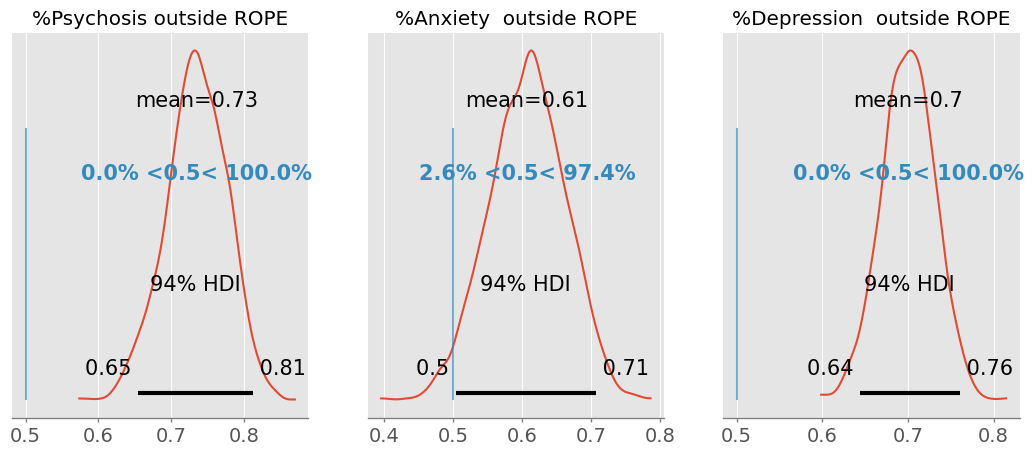

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(13, 5))
az.plot_posterior(psychosis_rope, ref_val=0.50, ax=axes[0])
axes[0].set_title("%Psychosis outside ROPE")
az.plot_posterior(anxiety_rope ,ref_val=0.50, ax=axes[1])
axes[1].set_title("%Anxiety  outside ROPE")
az.plot_posterior(depression_rope, ref_val=0.50, ax=axes[2])
axes[2].set_title("%Depression  outside ROPE")

In [26]:
psychosis_distrubtions = w_subjects[patient_wide_df['group'].str.contains("psychosis").values].mean("dim2").to_numpy()
anxiety_distrubtions = w_subjects[patient_wide_df['group'].str.contains("Anxiety").values].mean("dim2").to_numpy()
depression_distrubtions = w_subjects[patient_wide_df['group'].str.contains("Depression").values].mean("dim2").to_numpy()

In [27]:
rope_mass(psychosis_distrubtions)

{'inside': np.float64(14.7),
 'below': np.float64(68.8),
 'above': np.float64(16.5),
 'posterior_odds': np.float64(5.802721088435375),
 'bf_01': np.float64(0.1723329425556858)}

In [28]:
rope_mass(anxiety_distrubtions)

{'inside': np.float64(14.6),
 'below': np.float64(68.8),
 'above': np.float64(16.6),
 'posterior_odds': np.float64(5.8493150684931505),
 'bf_01': np.float64(0.17096018735362997)}

In [29]:
rope_mass(depression_distrubtions)

{'inside': np.float64(21.099999999999998),
 'below': np.float64(59.599999999999994),
 'above': np.float64(19.3),
 'posterior_odds': np.float64(3.739336492890995),
 'bf_01': np.float64(0.267427122940431)}

Text(0.5, 1.0, 'Depression Group Mean')

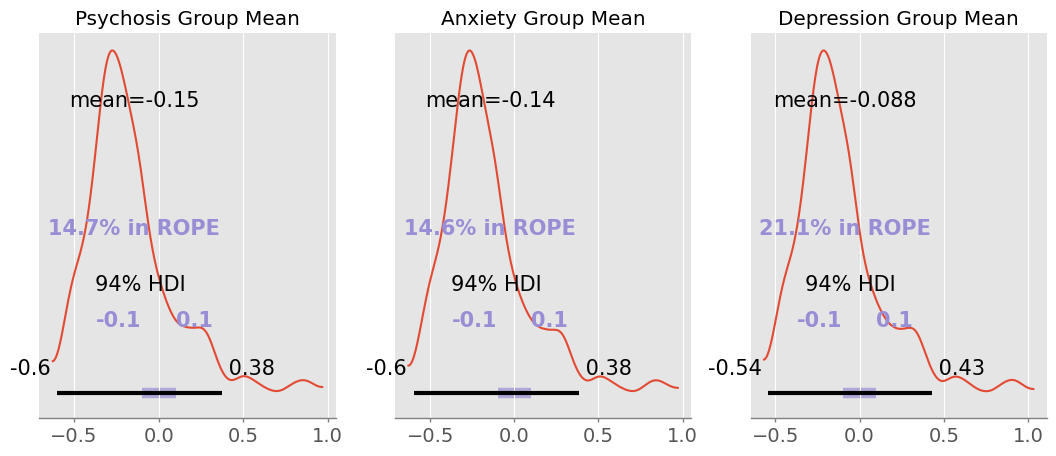

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(13, 5))
az.plot_posterior(psychosis_distrubtions ,rope=[-0.1, 0.1], ax=axes[0])
axes[0].set_title("Psychosis Group Mean")
az.plot_posterior(anxiety_distrubtions ,rope=[-0.1, 0.1], ax=axes[1])
axes[1].set_title("Anxiety Group Mean")
az.plot_posterior(depression_distrubtions ,rope=[-0.1, 0.1], ax=axes[2])
axes[2].set_title("Depression Group Mean")

Text(0.5, 1.0, 'Depression > psychosis Group Mean')

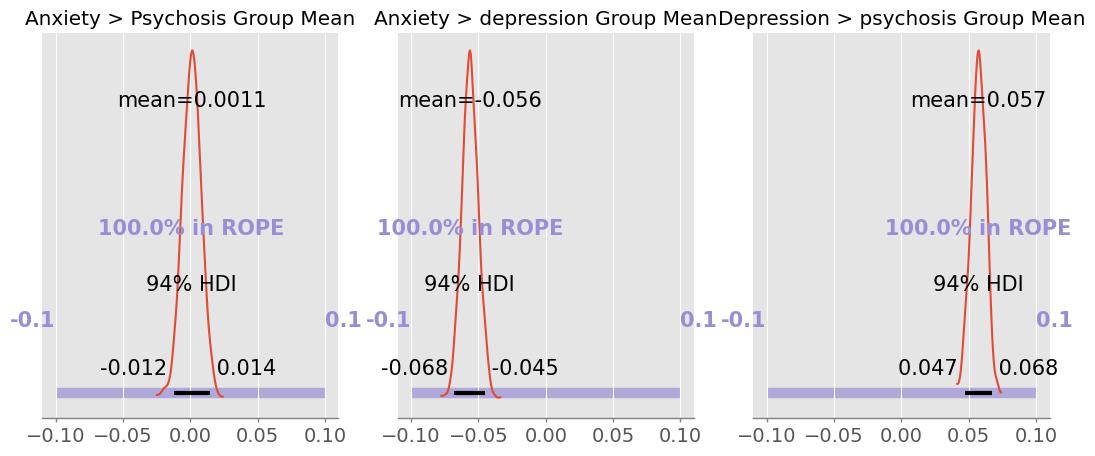

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(13, 5))
az.plot_posterior(anxiety_distrubtions - psychosis_distrubtions ,rope=[-0.1, 0.1], ax=axes[0])
axes[0].set_title("Anxiety > Psychosis Group Mean")
az.plot_posterior(anxiety_distrubtions - depression_distrubtions ,rope=[-0.1, 0.1], ax=axes[1])
axes[1].set_title("Anxiety > depression Group Mean")
az.plot_posterior(depression_distrubtions - psychosis_distrubtions ,rope=[-0.1, 0.1], ax=axes[2])
axes[2].set_title("Depression > psychosis Group Mean")

### Grey matter

In [32]:
summary_g = pd.concat([G_patients.reset_index(drop=True), g_summary.reset_index(drop=True)], axis=1)
subject_summary = summary_g.groupby(["subject", "group"]).agg(
    mean_across_components=("mean", "mean"),
    hdi_lower_mean=("hdi_2.5%", "mean"),
    hdi_upper_mean=("hdi_97.5%", "mean"),
).reset_index()
condition = (
    (subject_summary["mean_across_components"].abs() > 0.1) &
    (subject_summary["hdi_lower_mean"].abs() > 0.1) &
    (subject_summary["hdi_upper_mean"].abs() > 0.1)
)
subjects_outside_of_rope = subject_summary[condition]
psychosis_rope = beta_distribution(subjects_outside_of_rope[subjects_outside_of_rope['group'].str.contains("psychosis")].shape[0],
                                   subject_summary[subject_summary['group'].str.contains("psychosis").values].shape[0])
anxiety_rope = beta_distribution(subjects_outside_of_rope[subjects_outside_of_rope['group'].str.contains("Anxiety")].shape[0],
                                   subject_summary[subject_summary['group'].str.contains("Anxiety").values].shape[0])
depression_rope = beta_distribution(subjects_outside_of_rope[subjects_outside_of_rope['group'].str.contains("Depression")].shape[0],
                                   subject_summary[subject_summary['group'].str.contains("Depression").values].shape[0])

Text(0.5, 1.0, '%Depression  outside ROPE')

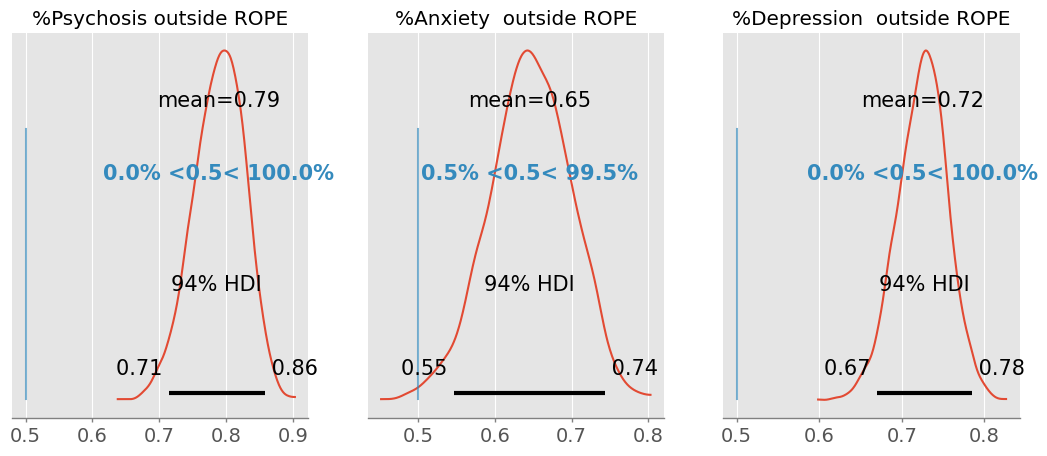

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(13, 5))
az.plot_posterior(psychosis_rope, ref_val=0.50, ax=axes[0])
axes[0].set_title("%Psychosis outside ROPE")
az.plot_posterior(anxiety_rope ,ref_val=0.50, ax=axes[1])
axes[1].set_title("%Anxiety  outside ROPE")
az.plot_posterior(depression_rope, ref_val=0.50, ax=axes[2])
axes[2].set_title("%Depression  outside ROPE")

In [34]:
psychosis_distrubtions = g_subjects[patient_wide_df['group'].str.contains("psychosis").values].mean("dim2").to_numpy()
anxiety_distrubtions = g_subjects[patient_wide_df['group'].str.contains("Anxiety").values].mean("dim2").to_numpy()
depression_distrubtions = g_subjects[patient_wide_df['group'].str.contains("Depression").values].mean("dim2").to_numpy()

In [35]:
rope_mass(psychosis_distrubtions)

{'inside': np.float64(23.0),
 'below': np.float64(59.5),
 'above': np.float64(17.5),
 'posterior_odds': np.float64(3.3478260869565215),
 'bf_01': np.float64(0.29870129870129875)}

In [36]:
rope_mass(anxiety_distrubtions)

{'inside': np.float64(33.5),
 'below': np.float64(40.0),
 'above': np.float64(26.5),
 'posterior_odds': np.float64(1.9850746268656716),
 'bf_01': np.float64(0.5037593984962406)}

In [37]:
rope_mass(depression_distrubtions)

{'inside': np.float64(28.000000000000004),
 'below': np.float64(50.8),
 'above': np.float64(21.2),
 'posterior_odds': np.float64(2.571428571428571),
 'bf_01': np.float64(0.38888888888888895)}

Text(0.5, 1.0, 'Depression Group Mean')

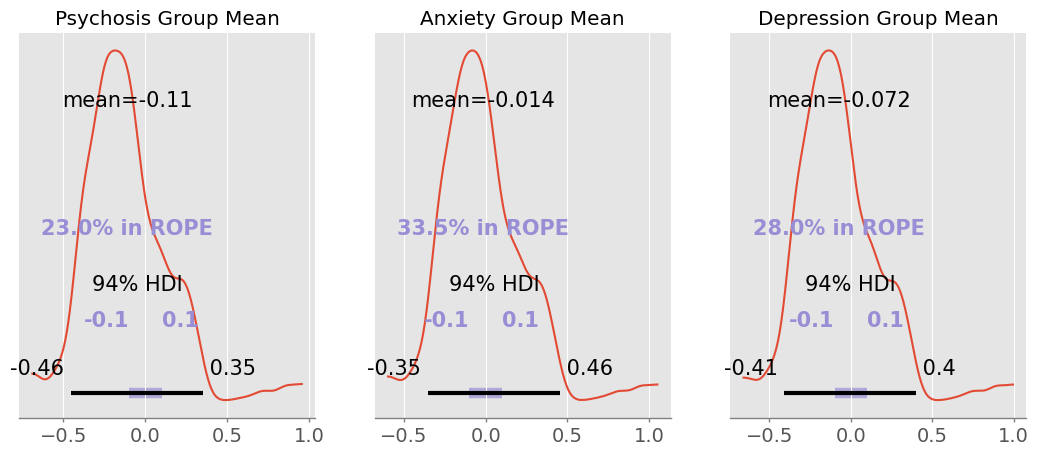

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(13, 5))
az.plot_posterior(psychosis_distrubtions ,rope=[-0.1, 0.1], ax=axes[0])
axes[0].set_title("Psychosis Group Mean")
az.plot_posterior(anxiety_distrubtions ,rope=[-0.1, 0.1], ax=axes[1])
axes[1].set_title("Anxiety Group Mean")
az.plot_posterior(depression_distrubtions ,rope=[-0.1, 0.1], ax=axes[2])
axes[2].set_title("Depression Group Mean")

Text(0.5, 1.0, 'Depression > psychosis Group Mean')

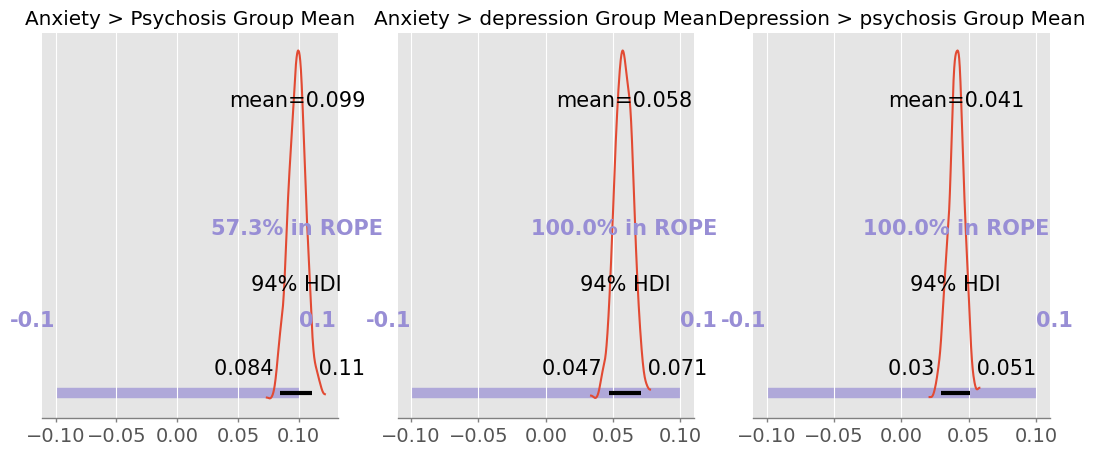

In [39]:
fig, axes = plt.subplots(1, 3, figsize=(13, 5))
az.plot_posterior(anxiety_distrubtions - psychosis_distrubtions ,rope=[-0.1, 0.1], ax=axes[0])
axes[0].set_title("Anxiety > Psychosis Group Mean")
az.plot_posterior(anxiety_distrubtions - depression_distrubtions ,rope=[-0.1, 0.1], ax=axes[1])
axes[1].set_title("Anxiety > depression Group Mean")
az.plot_posterior(depression_distrubtions - psychosis_distrubtions ,rope=[-0.1, 0.1], ax=axes[2])
axes[2].set_title("Depression > psychosis Group Mean")